# ------------- 安裝與載入套件 -------------
- 使用 miniconda 的用戶需要在這裡安裝一些套件

In [1]:
# conda install pandas
# !pip install git+https://github.com/APCLab/jieba-tw.git
# pip install pyLDAvis
# pip install sklearn
# conda install matplotlib
# conda install seaborn
# pip install python-igraph
# pip install cairocffi
# pip install glpk
# pip install wordcloud
# pip install googletrans
# !pip install snownlp
# pip install -U jiagu
# pip install nltk

In [1]:
import os
import gc
import re
import pandas as pd

import datetime
import igraph
import jieba
import jieba.analyse

import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
import opencc
from PIL import Image
# 視覺化套件
from matplotlib.font_manager import FontProperties
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 25)
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

# ------------- 使用套件 -------------
- [wordart.com](https://wordart.com/my-word-art)

# ------------- Facebook Crawler -------------
- [Facebook粉絲專頁爬蟲筆記](https://tlyu0419.github.io/2020/03/17/Crawl-Facebook-Pages)

# ------------- SNA -------------

## 整理資料
- 透過貼文ID抽取發文者和留言人的關係
- 透過留言ID吃去留言人和回覆人的關係

### 留言
檢視留言者與貼文者的互動

In [2]:
# # 讀取留言資料
# files = ['Comments_201911.pkl','Comments_201912.pkl','Comments_202001.pkl']
# Comments = []
# for i in files:
#     ndf = pd.read_pickle('data/Comments/'+ i)
#     ndf = ndf.loc[:,['NAME', 'AUTHOR', 'TIME', 'POSTID', 'COMMENTID','TEXT']]
#     gc.collect()
#     print(i, ndf.shape)
#     Comments.append(ndf)
# Comments = pd.concat(Comments, ignore_index=True)
# Comments.columns = ['SOURCE_NAME', 'SOURCE', 'TIME', 'POSTID', 'COMMENTID','TEXT']

# # 透過 PostID, 追蹤貼文的 Author
# Posts = pd.read_pickle('data/politic_posts.pkl')
# Posts = Posts.loc[:,['NAME','PAGEID','POSTID','TIME','CONTENT']]
# Posts = Posts.drop_duplicates(ignore_index=True)
# Posts = Posts.loc[:,['NAME', 'PAGEID', 'POSTID']]
# Posts.columns = ['TARGET_NAME', 'TARGET', 'POSTID']
# Comments = pd.merge(Comments, Posts, how='left', on='POSTID')

# # 去除沒有文字的留言(只有貼圖)
# Comments = Comments.loc[Comments['TEXT'].apply(lambda x: len(x))>=1]

# Comments.to_pickle('data/Interactive/Interactive_Comments.pkl')
# print(Comments.shape)
# Comments.head(3)

In [3]:
# del Comments

### 回覆 
檢視回覆者與留言者的互動

In [4]:
# # 讀取回覆資料
# files = os.listdir('data/Replies')
# files = ['Replies201911.pkl','Replies201912.pkl','Replies202001.pkl']
# Replies = []
# for i in files:
#     ndf = pd.read_pickle('data/Replies/'+ i)
#     ndf = ndf.loc[:,['NAME', 'AUTHOR', 'TIME', 'PARENTCOMMENTID','TEXT']]
#     gc.collect()
#     print(i, ndf.shape)
#     Replies.append(ndf)
# Replies = pd.concat(Replies, ignore_index=True)
# Replies.columns = ['SOURCE_NAME', 'SOURCE', 'TIME', 'PARENTCOMMENTID','TEXT']
# Replies['PARENTCOMMENTID'] = Replies['PARENTCOMMENTID'].apply(lambda x: x.split('_',-1)[-1])
# Replies = Replies.drop_duplicates(keep='first')
# print(Replies.shape)

# # 透過 CommentID 追蹤回覆是給 留言的 Author 
# files = ['Comments_201911.pkl','Comments_201912.pkl','Comments_202001.pkl']
# files = os.listdir('data/Comments')
# Comments = []
# for i in files:
#     ndf = pd.read_pickle('data/Comments/'+ i)
#     ndf = ndf.loc[:,['NAME', 'AUTHOR', 'COMMENTID']]
#     print(i, ndf.shape)
#     Comments.append(ndf)
# Comments = pd.concat(Comments, ignore_index=True)
# Comments.columns = ['TARGET_NAME', 'TARGET', 'COMMENTID']
# Comments = Comments.drop_duplicates('COMMENTID', keep='first')
# Replies = pd.merge(Replies, Comments, how='left', left_on='PARENTCOMMENTID', right_on='COMMENTID')

# # 去除沒有文字的回覆(只有貼圖的回覆)
# Replies = Replies.loc[Replies['TEXT'].apply(lambda x: len(x))>=1]

# Replies.to_pickle('data/Interactive/Interactive_Replies.pkl')
# print(Replies.shape)
# Replies.head(3)

In [5]:
# del Comments, Replies

## 匯入資料
- 將互動資料匯入igraph

In [6]:
# # 讀取資料
# Comments = pd.read_pickle('data/Interactive/Interactive_Comments.pkl')
# print(Comments.shape)
# # 每則貼文只萃取一次關聯
# Comments = Comments.drop_duplicates(['SOURCE_NAME', 'SOURCE', 'POSTID', 'TARGET_NAME', 'TARGET'], keep='first')
# print(Comments.shape)
# # 去除自我引用
# Comments = Comments.loc[Comments['SOURCE'] != Comments['TARGET'], :]
# print(Comments.shape)
# # 大選前二個月的資料
# Comments = Comments.loc[Comments['TIME'].between('2019-11-11','2020-01-11',True), ['SOURCE_NAME', 'SOURCE', 'TARGET_NAME', 'TARGET']]
# print(Comments.shape)
# Comments.head(3)

In [7]:
# # 讀取回覆資料
# Replies = pd.read_pickle('data/Interactive/Interactive_Replies.pkl')
# print(Replies.shape)
# # 每則留言只萃取一次關聯
# Replies = Replies.drop_duplicates(['SOURCE_NAME', 'SOURCE', 'PARENTCOMMENTID', 'TARGET_NAME', 'TARGET'], keep='first')
# print(Replies.shape)
# # 去除自我引用
# Replies = Replies.loc[Replies['SOURCE'] != Replies['TARGET'], :]
# print(Replies.shape)
# # 大選前二個月的資料
# Replies = Replies.loc[Replies['TIME'].between('2019-11-11','2020-01-11',True), ['SOURCE_NAME', 'SOURCE', 'TARGET_NAME', 'TARGET']]
# print(Replies.shape)
# Replies.head()

In [8]:
# Interact = pd.concat([Comments, Replies], ignore_index = True)
# Interact = Interact.groupby(['SOURCE_NAME', 'SOURCE','TARGET_NAME', 'TARGET']).size().reset_index()
# Interact.columns = ['SOURCE_NAME', 'SOURCE', 'TARGET_NAME', 'TARGET', 'WEIGHT']
# print(Interact.shape)
# Interact.head()

In [9]:
# del Comments, Replies

In [10]:
# # 建立 vertex 清單
# vertices = pd.concat([Interact.loc[:,['SOURCE','SOURCE_NAME']].rename(columns={'SOURCE': 'VERTEX', 'SOURCE_NAME': 'VERTEX_NAME'}),
#                       Interact.loc[:,['TARGET','TARGET_NAME']].rename(columns={'TARGET': 'VERTEX', 'TARGET_NAME': 'VERTEX_NAME'})],
#                      ignore_index=True)
# vertices = vertices.drop_duplicates(['VERTEX'], keep='first')
# print(vertices.shape)
# vertices.head(3)

In [11]:
# g = igraph.Graph(directed=True)

# # 加入 vertex 資訊
# for vertex in vertices['VERTEX']:
#     g.add_vertex(str(vertex))
    
# # 加入 node 的 label
# g.vs['label'] = vertices['VERTEX_NAME'].values
# del vertices
# igraph.summary(g)

In [12]:
# # add edges
# edges = [(source, target) for source, target in zip(Interact['SOURCE'], Interact['TARGET'])]
# g.add_edges(edges)
# igraph.summary(g)
# # add weights
# g.es['weight'] = Interact['WEIGHT'].values
# igraph.summary(g)

## 節點重要性評估
- SNA如何評估節點重要性__透過 SNA 來從新認識KOL
    - degree(接觸人的數量/缺點是假賬號衝讚、分享數)
    - Closeness:計算到每個點到其他點的平均最短路徑，數字越小表示越在網絡的核心，距離其他節點的遠近程度(是否位在空間的中心位置)
    - betweeness:計算被經過的次數(必經之地如公文，在階級結構鮮明的組織較適合使用)
    - pagerank：將in-link視為具有聲望+遞迴計算。因為網站上面會有很多垃圾網站，為了避免被錯誤的估計重要性，導入了一個概念是「被重要的人引用應該比被不重要的人引用來的重要」。被假賬號的人留言，跟被蔡英文留言的意義完全不同
    - eigenvector:
    eigenvector_centrality
    eigenvector_centrality(directed=True, scale=True, weights=None, return_eigenvalue=False, arpack_options=None)
- Ref
    - [如何简单地理解中心度，什么是closeness、betweenness和degree](https://www.zhihu.com/question/22610633/answer/493452601)
    - [社区网络分析学习笔记 —— 算法实现及 igraph 介绍](https://zhuanlan.zhihu.com/p/40227203)
    - [学习笔记（1）：igraph 社区网络算法 分析《权力的游戏》Part 1](https://zhuanlan.zhihu.com/p/24881204)

In [13]:
# # degree
# # g.vs['degree'] = g.vs.degree(mode='ALL', loops=False)

# # indegree
# g.vs['indegree'] = g.vs.degree(mode='IN', loops=False)

# # outdegree
# g.vs['outdegree'] = g.vs.degree(mode='OUT', loops=False)

# # betweeness
# g.vs['betweenness'] = g.vs.betweenness(directed=True, weights='weight')

# # closeness
# g.vs['closeness'] = g.vs.closeness(weights='weight')

# # pagerank
# g.vs['pagerank'] = g.pagerank(directed=True, weights='weight')

In [14]:
# g.write_pickle("sna_graph_data_L60D.pkl")

## 找出 KOL 
- 計算每個節點在4個指標的重要性，並透過 pagerank 找出 KOL
- 在進行分析是需依產業/專案的需求選擇合適的指標

In [2]:
g = igraph.Graph.Read_Pickle('sna_graph_data_L60D.pkl')
igraph.summary(g)

IGRAPH DNW- 362535 577553 -- 
+ attr: betweenness (v), closeness (v), indegree (v), label (v), name (v), outdegree (v), pagerank (v), weight (e)


In [3]:
vertices_info = pd.DataFrame({'name':g.vs['name'],
                              'label':g.vs['label'],
                              'indegree':g.vs['indegree'],
                              'outdegree':g.vs['outdegree'],
                              'betweenness':g.vs['betweenness'],
                              'closeness':g.vs['closeness'],
                              'pagerank':g.vs['pagerank']})
vertices_info.head()

,name,label,indegree,outdegree,betweenness,closeness,pagerank
0,1471596177,Bill Leung,0,1,0.0,0.003465,5.997065e-07
1,567327586,'Ash Jackson,0,1,0.0,0.003465,5.997065e-07
2,100000851859077,'Billy Li,0,1,0.0,0.003465,5.997065e-07
3,1660063953,'Vicky Lee',0,1,0.0,0.003453,5.997065e-07
4,100000258321181,'Wei Chi Lee',0,1,0.0,0.003383,5.997065e-07


In [4]:
# 再把這邊先用 sqrt 去除偏態，接著再用 minmax
cols = ['indegree', 'outdegree', 'betweenness', 'closeness', 'pagerank']
for i in cols:
    vertices_info[i+'_nm'] = np.sqrt(vertices_info[i])
    vertices_info[i+'_nm'] = MinMaxScaler().fit_transform(vertices_info.loc[:,[i+'_nm']])
vertices_info['score'] = vertices_info['indegree_nm'] + vertices_info['outdegree_nm'] + vertices_info['betweenness_nm'] + vertices_info['closeness_nm'] + vertices_info['pagerank_nm']

kols = vertices_info.sort_values(by='score',ascending=False)

# 從各個指標各自選前 10人來畫圖，呈現不同指標下會找出不同的 KOL
kols = pd.concat([vertices_info.sort_values(by='indegree',ascending=False).head(10),
                  vertices_info.sort_values(by='outdegree',ascending=False).head(10),
                  vertices_info.sort_values(by='betweenness',ascending=False).head(10),
                  vertices_info.sort_values(by='closeness',ascending=False).head(10),
                  vertices_info.sort_values(by='pagerank',ascending=False).head(10)],
                 ignore_index=True)
kols = kols.drop_duplicates().sort_values(by='score',ascending=False).head(30)
kols.shape

(30, 13)

In [5]:
# kols['label'].values

In [6]:
# 基於保護個資的原因，做簡報時需要將姓名隱碼

# ids = ['46251501064', '1863023523934803', '100000359856261','100023374938298', '100041581207571',
#        '100000206815097', '100013438365007', '100009219531853', '100002735882493','100004232837316', 
#        '100002068981370', '491399324358361', '100008031423962', '528994842', '100007359360367',
#        '100000137657309', '100010120840330', '100000172803121', '100026101807125', '100038192678320', 
#        '100000237672790', '100004722182299', '100001876335501', '100000516050991', '100000288512220',
#        '100009533631280', '100006213755698', '100006855841686', '769328496', '105497726206174']

# labels = ['蔡英文', '韓國瑜', 'Allen**', '蔡**', 'Grande**', 'Chuchu**', '沙**', '李**', '余**', '楊**',
#           'Zhao**', '宋楚瑜', 'Poco**', 'Berenice**', '胡**','Winnie**', '張**', '法**', '董**', '黃**',
#           '陳**', '劉**', 'Chung**', '焦**', 'Dillan**', '神**', '劉**', '蔡**', 'Mia**', '王**']

# for ID, LABEL in zip(ids, labels):
#     kols.loc[kols['name']==ID,'label']=LABEL

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

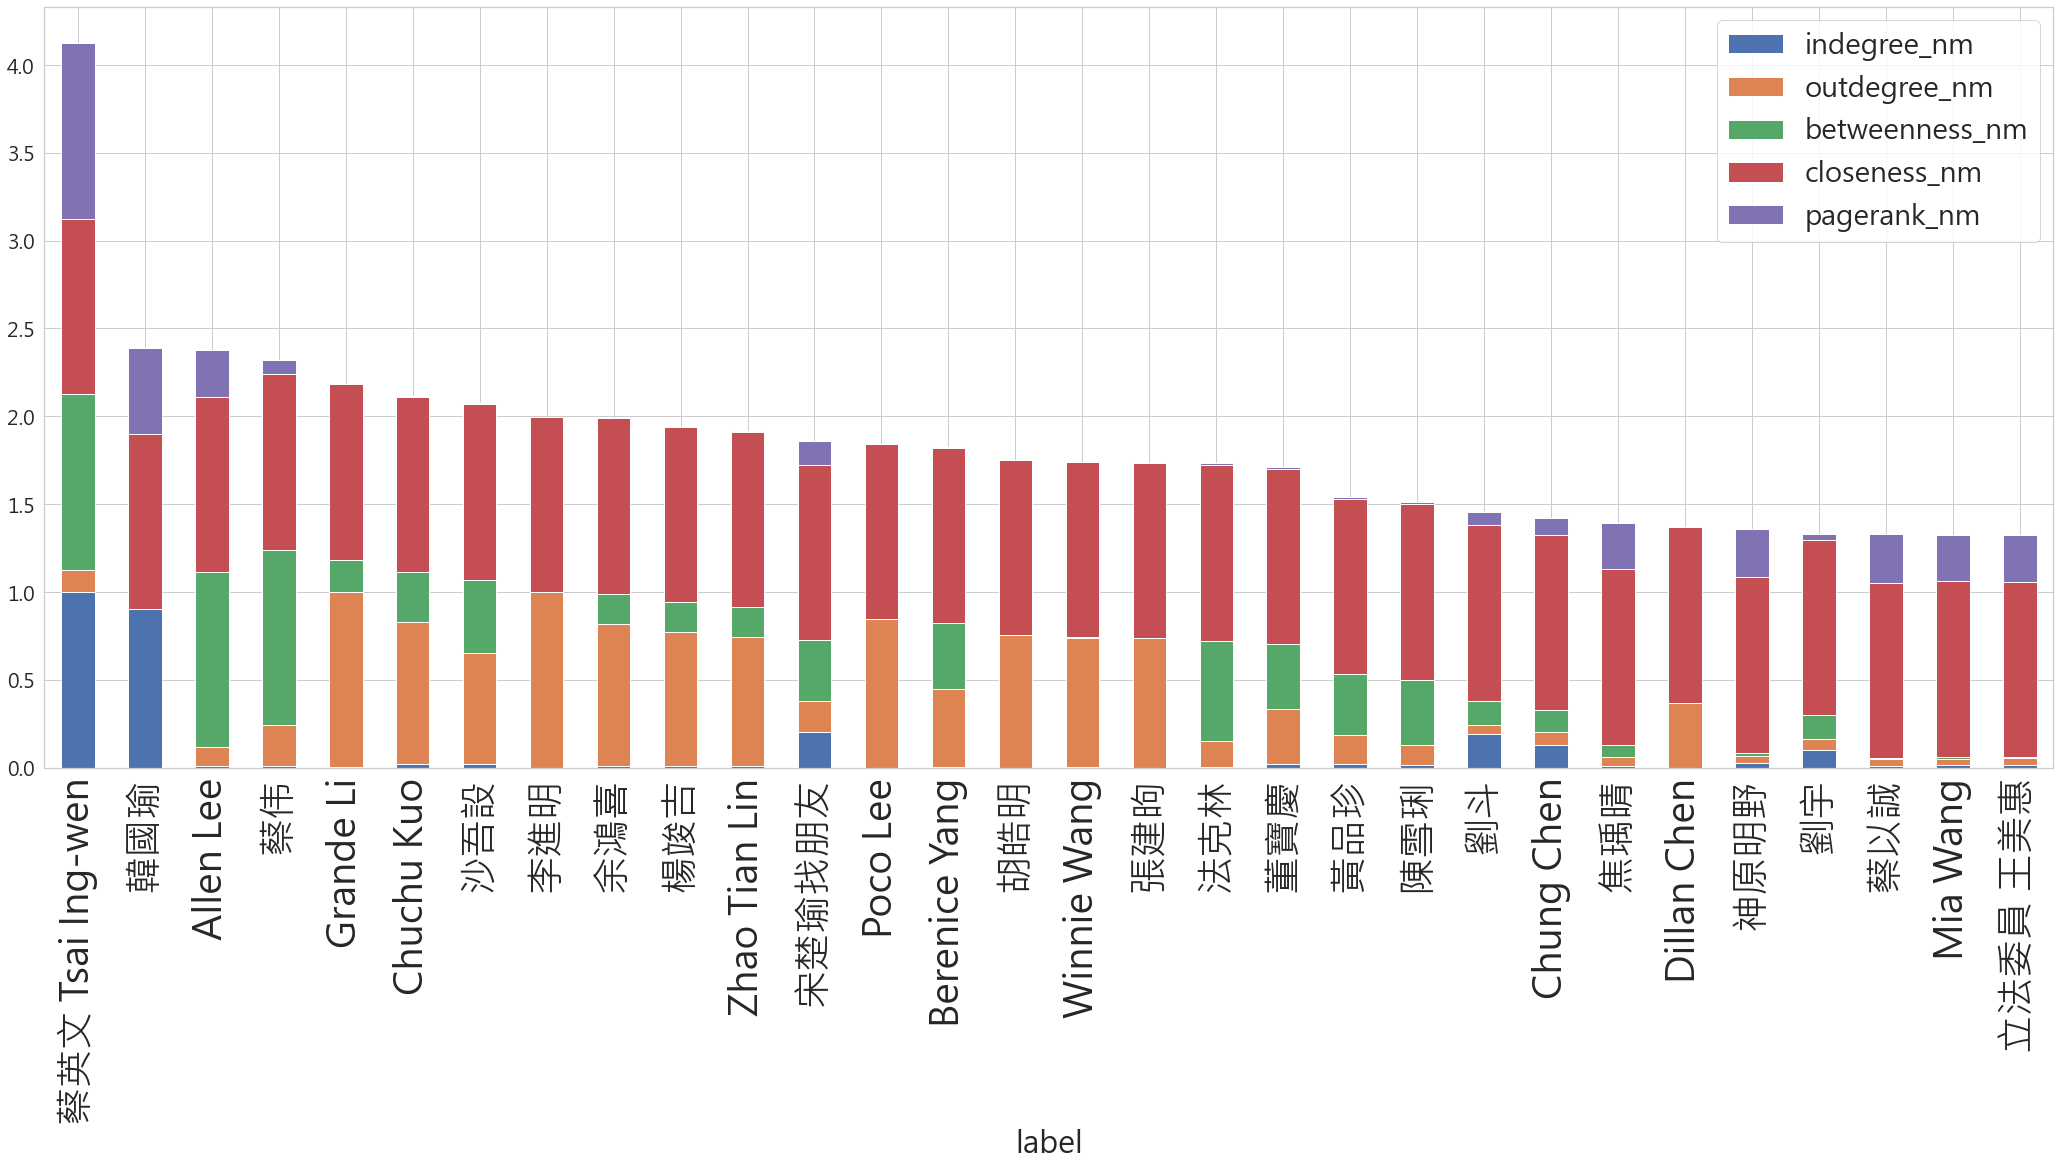

In [7]:
sns.set(style="whitegrid",font_scale=2.5,font='Microsoft JhengHei')# 
plt.rcParams["figure.figsize"] = [36, 14]
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
kols.loc[:,['label', 'indegree_nm', 'outdegree_nm', 'betweenness_nm', 'closeness_nm', 'pagerank_nm']].set_index('label').plot(kind='bar', style='seaborn',stacked=True)
plt.xticks(size = 38)

## KOL的互動行為
- 視覺化 KOL 之間如何互動
- who is in your network, who is not?
  - 候選人身邊有哪些KOL?
  - 跟你很靠近的人就是支持你嗎?(發現：韓/蔡/宋身邊的 KOL不乏許多反對的聲音)
- 參考資料
    - [igraph 社交网络分析](http://rstudio-pubs-static.s3.amazonaws.com/484205_48e8ef6ea31b4bb7a11746c988da39de.html)
    - [igraph_layout-algorithms](https://igraph.org/python/doc/tutorial/tutorial.html#layout-algorithms)

In [8]:
# 過濾掉 indegree 太少的 KOLS
kols = vertices_info.loc[vertices_info['indegree'].apply(lambda x: x>=20),:]
kols = kols.sort_values(by='pagerank',ascending=False).head(100)
print(kols.shape)
kols.head(10)

(100, 13)


,name,label,indegree,outdegree,betweenness,closeness,pagerank,indegree_nm,outdegree_nm,betweenness_nm,closeness_nm,pagerank_nm,score
275399,46251501064,蔡英文 Tsai Ing-wen,185882,12,3.554326e+09,0.003477,0.325444,1.000000,0.125822,1.000000,1.000000,1.000000,4.125822
361913,1863023523934803,韓國瑜,150845,0,0.000000e+00,0.003474,0.078621,0.900838,0.000000,0.000000,0.999581,0.490818,2.391237
253670,100009533631280,神原明野,158,1,1.325946e+06,0.003469,0.025278,0.029155,0.036322,0.019315,0.998918,0.277720,1.361429
270090,100006855841686,蔡以誠,20,1,1.938619e+05,0.003465,0.025236,0.010373,0.036322,0.007385,0.998336,0.277483,1.329898
72120,769328496,Mia Wang,47,1,4.458442e+05,0.003465,0.023067,0.015901,0.036322,0.011200,0.998307,0.265232,1.326962
254684,105497726206174,立法委員 王美惠,55,1,1.289100e+05,0.003469,0.023065,0.017201,0.036322,0.006022,0.998923,0.265222,1.323691
356072,100009404025938,黃祥和,21,1,1.565360e+05,0.003469,0.023059,0.010629,0.036322,0.006636,0.998825,0.265185,1.317597
154504,491399324358361,宋楚瑜找朋友,7717,24,4.237897e+08,0.003464,0.005838,0.203754,0.177939,0.345300,0.998196,0.132756,1.857945
21534,100001876335501,Chung Chen,3115,4,5.482137e+07,0.003464,0.003248,0.129452,0.072643,0.124193,0.998192,0.098685,1.423165
335654,232716627404,陳菊(花媽),355,1,2.031269e+06,0.003464,0.002307,0.043701,0.036322,0.023906,0.998111,0.082948,1.184987


In [9]:
# # 做簡報時使用，考量個資將姓名移除
# sg = g.subgraph(kols['name'])
# sg.vs['label'] = ''
# layout = sg.layout_kamada_kawai(maxiter=10000)
# igraph.plot(sg, layout = layout,bbox=(0,0,600,500))

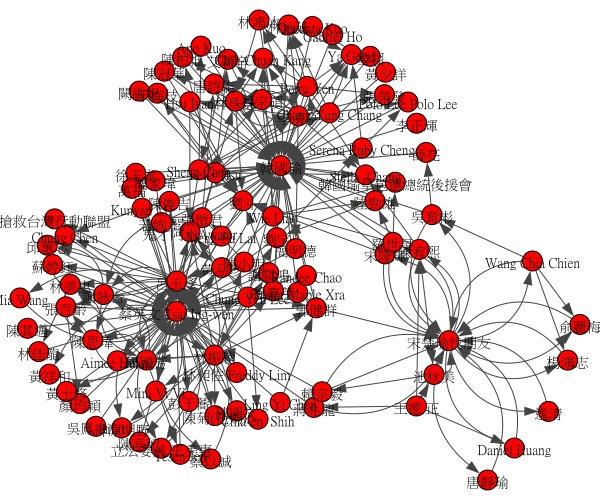

In [10]:
sg = g.subgraph(kols['name'])
layout = sg.layout_kamada_kawai(maxiter=10000)
igraph.plot(sg, layout = layout,bbox=(0,0,600,500))

# ------------- NLP -------------
- NLP流程
    - 轉繁體
    - 斷詞
    - 濾除停用詞
    - topicmodel

## 主題分析

### 讀取資料

In [11]:
# 抓取留言
comments = pd.concat([pd.read_pickle('data/Interactive/Interactive_Comments.pkl').loc[:,['SOURCE_NAME', 'SOURCE', 'TARGET_NAME', 'TARGET', 'TIME', 'TEXT']],
                      pd.read_pickle('data/Interactive/Interactive_Replies.pkl').loc[:,['SOURCE_NAME', 'SOURCE', 'TARGET_NAME', 'TARGET', 'TIME', 'TEXT']]],
                     ignore_index=True)
comments = comments.loc[comments['TIME'].between('2019-11-11','2020-01-11',True),:]
print(comments.shape)

# 用戶名稱列表，後續用來當做停用詞
name_list = list(set(list(comments['SOURCE_NAME']) + list(comments['TARGET_NAME'])))

# 只保留 KOL 的說話內容
comments = pd.merge(left = comments,
                    right = kols.loc[:,['name']],
                    how = 'left',
                    left_on='SOURCE',
                    right_on='name',
                    indicator=True)
comments = comments.loc[comments['_merge']=='both',['SOURCE','SOURCE_NAME','TIME','TEXT']]
# 去除一直複製貼上的留言內容
comments = comments.drop_duplicates(['SOURCE','TEXT'],keep='first')

print(comments.shape)
comments.head(3)

(1692141, 6)
(14889, 4)


,SOURCE,SOURCE_NAME,TIME,TEXT
307,100000379747963,郭健群,2019-11-14 00:52,宋楚瑜總統，捍衛中華民國， 知識藍，經濟藍...
356,100001471361107,Wang Chia Chien,2019-11-13 19:52,人人都可選總統👍💪💪💪💪
382,100001471361107,Wang Chia Chien,2019-11-13 23:18,宋主席謝謝您！😭我投您，因為您是選賢與能最...


In [12]:
comments = comments.groupby(['SOURCE','SOURCE_NAME'])['TEXT'].apply(lambda x: ' '.join(x)).reset_index()
print(comments.shape)
comments.head(3)

(100, 3)


,SOURCE,SOURCE_NAME,TEXT
0,100000036710110,張百齡,賴功德啊？ 卡撐事件，空心菜回答的結結巴巴...
1,100000042799436,陳俊吉,"坦白講,我不曾投過民進黨!而且因為阿扁甚至..."
2,100000106545512,陳冠華,好想當砂石場大亨 溜之大吉~酸，烙跑市長在...


### 簡繁轉換
- 簡繁字的區辨還需人工檢視，無法從編碼區分
- 直接轉換會把「吃」變成「喫」，「台」變成「臺」

In [13]:
converter = opencc.OpenCC('s2t.json')
# 徐嘉苧
comments.loc[comments['SOURCE']=='100003799310172','TEXT'] = converter.convert(comments.loc[comments['SOURCE']=='100003799310172','TEXT'].values[0])
# 徐玉龙
comments.loc[comments['SOURCE']=='100004358619003','TEXT'] = converter.convert(comments.loc[comments['SOURCE']=='100004358619003','TEXT'].values[0])
comments.head()

,SOURCE,SOURCE_NAME,TEXT
0,100000036710110,張百齡,賴功德啊？ 卡撐事件，空心菜回答的結結巴巴...
1,100000042799436,陳俊吉,"坦白講,我不曾投過民進黨!而且因為阿扁甚至..."
2,100000106545512,陳冠華,好想當砂石場大亨 溜之大吉~酸，烙跑市長在...
3,100000169348902,若絢 閻,韓總統，口說好話，身形好事，心有善念，跟韓...
4,100000189732330,Queenta Kuo,百年一見政治騙子 一群人生失敗組在這邊教訓...


### 同義詞
同義詞或錯別字都一起在這裡修正

In [14]:
comments['TEXT'] = comments['TEXT'].apply(lambda x: re.sub('臺','台',x))
comments['TEXT'] = comments['TEXT'].apply(lambda x: re.sub('甚麼','什麼',x))
comments['TEXT'] = comments['TEXT'].apply(lambda x: re.sub('棟蒜','凍蒜',x))
comments['TEXT'] = comments['TEXT'].apply(lambda x: re.sub('韓倒','韓導',x))
comments['TEXT'] = comments['TEXT'].apply(lambda x: re.sub('綐統','總統',x))
comments['TEXT'] = comments['TEXT'].apply(lambda x: re.sub('落跑','烙跑',x))

### 去除標點、特殊符號

In [15]:
# 將非中文的文字、符號替換成空白
comments['TEXT2'] = comments['TEXT'].apply(lambda x: ''.join(re.sub('[^\u4e00-\u9fa5]', ' ', x))) 
comments['TEXT2'] = comments['TEXT2'].apply(lambda x: re.sub('[ ]{1,}', ' ', x))
print(comments.shape)
comments.head(5)

(100, 4)


,SOURCE,SOURCE_NAME,TEXT,TEXT2
0,100000036710110,張百齡,賴功德啊？ 卡撐事件，空心菜回答的結結巴巴...,賴功德啊 卡撐事件 空心菜回答的結結巴巴 ...
1,100000042799436,陳俊吉,"坦白講,我不曾投過民進黨!而且因為阿扁甚至...",坦白講 我不曾投過民進黨 而且因為阿扁甚至...
2,100000106545512,陳冠華,好想當砂石場大亨 溜之大吉~酸，烙跑市長在...,好想當砂石場大亨 溜之大吉 酸 烙跑市長在...
3,100000169348902,若絢 閻,韓總統，口說好話，身形好事，心有善念，跟韓...,韓總統 口說好話 身形好事 心有善念 跟韓...
4,100000189732330,Queenta Kuo,百年一見政治騙子 一群人生失敗組在這邊教訓...,百年一見政治騙子 一群人生失敗組在這邊教訓...


### 斷詞
- 有意義的最短組合
- 感覺直接去爬教育部的詞典、成語詞典最快 Orz
- 停用詞留在sklearn / gensim在做，不然自己慢慢偵測每個詞在不在wtopwords的list會跑到天荒地老
- 比較
  - jieba：上手最簡單的斷詞套件，但是需要針對詞典做優化
  - ckiptagger：中研院釋出的斷詞系統，威力不用質疑，但是套件相當肥大，如果你跟我一樣只有8G的RAM那你會用的相當崩潰
  - Spacy：2020.06開始支援中文，但是自定義詞典的地方不太容易使用

In [16]:
# stopwords = [
#     # 稱謂
#     '小姐', '我們', '大家', '你們', '您們', '哥哥', '自己', '葛格','大師兄','姐姐','美女','帥哥','老婆','小編','朋友','主管',
#     '阿姨', '他們', '人家', '大叔', '美人', '別人', '家人', '姊姊', '爸爸', '女兒',
#     # 時間
#     '明天','今天','下午','剛剛','每天','目前','今晚','明年','小時', '現在','即將','時間','今年', '昨天','未來','去年','之後',
#     # 打招呼
#     '安安','請問','晚安', '早安','感謝','午安','之前','科科','顆顆','哈哈', '謝謝',
#     # 地區
# #     '台北','新北','桃園','新竹','苗栗','台中',''

#     # 其他
#     '就是', '可以', '分享', '很多', '同一', '沒錯', '好像', '這一', '棒棒', '不用', '怎樣', '人物', '幫忙', '什麼', '一定', '沒有', '不要', '真的', '一起', '加入', '直播', '為了',
#     '這是', '因為', '為何', '不會', '所以', '怎麼', '還是', '這麼', '一直', '呵呵', '人數', '這邊', '好好','出來講','之外','錯字','加拿大','老大','請勿','在意', '不錯','臉書'

#     '只有', '多少', '一下', '開始', '趕快', '必須', '但是', '雖然', '覺得', '起來', '會去', '時候', '厲害','全形', '大寫', '空白鍵', '換行','觀看',
#     '開心', '就算', '快樂', '健康', '那邊', '比較', '哪裡', '等等', '這樣', '知道', '那一', '看到','快到','管好','一趟',
#     '以為', '這裡', '一點', '鍋鍋', '幹嘛', '不然', '美麗', '不再', '好了', '是否', '變成', '還要', '真好',
#     '舒心', '重要', '如果', '已經', '應該', '可是', '看看', '無法', '那麼', '到底', '非常', '當然', '了解',
#     '愉快', '如何', '只是', '也許', '辛苦', '其實', '果然', '原來', '留言', '真是', '出來', '清楚', '事情',
#     '願意', '不過', '不管', '新版', '可能',  '然後', '不能', '英版', '而已', '喜歡', '只要',
#     '告訴', '感覺', '認真', '認為', '需要', '可怕', '愛心', '下去', '當上', '努力', '隨便', '不同', '太多',
#     '所有', '結果', '事實', '萬人', '決定', '對了', '如此', '表現', '竟然', '滿滿', '一樣',
#     '不懂', '代表', '生活', '再度', '至少', '面對', '根本', '勇敢', '更多', '表示', '問題', '舒眠', '害怕',
#     '祈禱', '回來', '忘記', '開樓', '正在', '而且', '現場', '祝福', '能夠', '再次', '都會', '回答', '忘了',
#      '攻擊', '文化', '影片', '歡迎', '當初', '拜託','適合', '幸福', '通過', 
#     '希望', '孩子', '超過', '萬歲', '沒錯', '參加', '最後', '難聽', '賺錢', '好嘛','拿去',
#     '長相', '彷彿', '機構', '惹毛', '流程', '不懂', '神聖', '不必', '正確', '感動','這麼多','人民','檳榔','出去','車隊', '委員',
#     '總統','副總統', '台灣', '最好', '除了', '建議', '選區', '支持',
    
#     '為什麼', '有沒有', '憑什麼', '要不要', '對不起','再不然','不知道', '公部門', '李賢','難道','沒關係','附近','拍照','刪文','誤會','金錢','王森','準備'
#     '好朋友', '那麼多', '檳榔汁', '不知道', '鄉公所','第一次','卓昆霖','熊有田', '林慶苗', '劉斗', '陳冠綾', '劉宥蒼', '曾羽筑','何國興','蔡致宏','林裕翔','洪大松','鍾寶和',
#     '龔慶喜', '龔敬文', '龔文忠', '龚成斌', '龜投','楚江明王','蔡英文','張善政','宋楚瑜'
#     ]  + name_list # 用戶名稱

In [17]:
news = pd.read_csv('keywordsfromnews.csv')
keywords = []
for i in news['KEYWORDS']:
    try:
        keywords += i.split(',', -1)
    except:
        pass

words = [
    # 人物
    '韓國瑜', '國瑜', '韓市長', '韓總統', '韓國輸', '韓先生', '韓總', '韓總機', '草包','賣菜郎',
    '吳敦義','白賊義','吳主席',
    '馬英九','馬總統',
    '侯友宜','候市長',
    
    '李燈灰','李登輝',
    '蔡英文','小英','蔡總統','菜陰魂','菜菜子','小英總統',
    '陳水扁','阿扁',
    '賴清德', '賴功德',
    '宋楚瑜', '宋省長','宋先生','宋伯伯','宋爺爺','宋主席','宋北北','宋盤仔','宋杯杯',
    '蕭美琴',
    '楊蕙如','卡神','潘恆旭',
    '柯文哲',
    '習近平','洗淨平','習維尼','習大大',
    '蕭美琴','國昌','老師','樹菊',
    '黃少詳',
    # 稱謂
    '中華民國','總統','副總統','台灣',
    
    # 政黨
    '國民黨','中國國民黨','政府','國冥黨',
    '民進黨','民主進步黨','民主退步黨','冥盡黨',
    '親民黨',
    '民眾黨','台灣民眾黨',
    '時代力量',
    '台灣基進', '基進黨',
    '共產黨','中國','中共','中華人民共和國',
    '美國',
    
    # 政策/口號
    '國家', '人民有錢', '庶民','總統', '國政','領航', '發財', '發大財', '愛情', '摩天輪', '產業鏈', '接地氣',
    '辣台派', '英眼部隊','國會','過半','立委','唯一支持','民主','自由','台商','回流','和平協議','國防','產業',
    '藍綠','惡鬥','對立','台灣安全','勞工',
    '貿易戰',
    # 地區
    '台北','新北','桃園','新竹','苗栗','台中','高雄',
    
    # 議題
    '假新聞','假帳號','假民調','黑韓','韓黑','抹黑','抹紅','共諜','國家機器','中天','全民防睹','敵對勢力','網軍',
    '香港','台灣','香港',
    '走私菸',
    '一國兩制','一帶一路', '舔共','保台抗中','九二共識','武力威脅','捍衛','團結','主權','獨立','捍衛','主權'#'護台灣','顧台灣','點亮台灣','守護台灣','台灣獨立','台灣總統'
    '忘記','承諾','請假','逃跑',
    '烙跑',
    '棄韓','保宋','棄蔡',
    '環境保護',
    '光復高雄',
    '青年就業','就學貸款',
    '不分區','安全名單',
    '海角七億','賄選',
    '下架','小英','翻轉','罪有英德',
    '不分區名單',
    '總統票','立委票','政黨票','記得',
    '走私','倒扁', '王小姐','難民法',
    # 謾罵
    '低能','噩耗','智商','幹你娘','雞掰','不要臉','假掰','沒人性','笑死','唬爛','嘔嘔','低俗','潘金蓮','騙選票','笑話',
     '嘴砲','護香港', '難看', '吃相','結結巴巴','愛台灣', '挑撥', '後悔','馬屁','自婊','韓粉腦','洗腦', '噁心', '白癡',
    '落跑','淪落', '降低', '負評','保衛戰'
    # 其他
    '經濟','政策','台灣人民','執政者','全民運動','最後勝利', '第十五屆','人民幣','人權','直轄市','市長','一樣爛','政治人物',
    '北農','總經理','認證','總統候選人','講幹話','立法程序','砂石場','韓粉','韓家軍','候選人','總統','副總統','知識藍','經濟藍',
    '興達','發電廠','臨港','工業區','林園','工業區','捐款','收據','畫大餅','演講片段', '指責', '區域立委','樓中樓','不支持','王小姐',
    '關係','想太多','上街頭','上一代','負能量', '正當性', '高雄市民', '高雄市長','黨主席','財力證明','關你屁事','偏頗','公共危險',
    '鬼遮眼','香港人','對立面','不認同','唯一選項', 
    
    # 成語
    '自導自演', '可待商榷', '白紙黑字', '選賢與能', '大是大非', '廢話連篇', '子虛烏有', '堅定不移', '微微一笑', '普世價值', '道德標準', '大放厥詞', '口口聲聲', '殫精竭慮', '璀璨亮麗', '生命垂危', '為國為民',
    '吃喝嫖賭', '吃香喝辣', '高票當選', '全力支持', '拐彎抹角', '不予置評', '無能為力', '闔家光臨', '支支吾吾', '從不放棄', '借題發揮', '歡迎回來', '子子孫孫', '平安快樂', '世界和平', '百業興旺', '苦民所苦',
    '多說無益', '模稜兩可', '健康快樂', '新年快樂', '一聲令下', '使命必達', '樸實無華', '說三道四', '競選總部', '越來越多', '閃電攻擊', '轟轟烈烈', '轉移焦點', '暗無天日', '重啟核四', '人民福祉', '優良傳統',
    '毫無意義', '國家大事', '胡說八道', '人身安全', '執政團隊', '睿智堅毅', '始終相信', '非韓不投', '短線套利', '愛心捐款', '選舉風氣', '自由民主', '主辦單位', '國際社會', '苦不堪言', '台灣良心', '斷章取義',
    '江湖術士', '回頭是岸', '國泰平安', '風調雨順', '挺韓遊行', '展翅高飛', '翱翔四海', '延伸閱讀', '重出江湖', '人民幸福', '國家機密', '看不下去', '依然相信', '得來不易', '溜之大吉', '更多影片', '互動內容',
    '弱勢族群', '有待商確', '一路走來', '堅持初衷', '助紂為虐', '務必支持', '上樑不正', '據我所知', '一步一步', '安安靜靜', '遍地開花', '道聽塗說', '拒絕回答', '國際媒體', '出一張嘴', '口說好話', '理所當然',
    '帶頭作亂', '馬齒徒長', '艱難險阻', '默默付出', '衷心感謝', '貌合神離', '全力衝刺', '風雨無阻', '一飛沖天', '撲天蓋地', '屹立不搖', '六親不認', '千錘百鍊', '聲嘶力竭', '人身攻擊', '一個中國', '一邊一國', 
    '棄韓保宋', '八百壯士', '四行倉庫', '生龍活虎', '關門打狗', '甕中捉鱉', '八人大轎', '政治渣男', '歸根究柢', '九霄雲外', '世界工廠', 
    '肝膽相照', '左右開弓', '傷天害理', '天理難容', '萬事如意', '證據確鑿', '擇善固執', '無限上綱', '無法無天', '棄暗投明', '腳踏實地',
    '臉上無光', '乞丐趕廟公','道不同不相為謀']

keywords = list(set(keywords + words + name_list))
len(keywords)

309027

In [18]:
for i in keywords:
    try:
        jieba.add_word(i)
    except:
        pass
print('Complete!')

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\TL_Yu\AppData\Local\Temp\jieba.cache
Loading model cost 1.996 seconds.
Prefix dict has been built successfully.


Complete!


In [19]:
def sent2words(sent):
    words = []
    for i in jieba.lcut(sent):
        if len(i) >= 2:
            words.append(i)
    words = ' '.join(words)
    return  words

In [20]:
comments['TEXT3'] = comments['TEXT2'].apply(lambda x: sent2words(x))
print(comments.shape)
comments.head(2)

(100, 5)


,SOURCE,SOURCE_NAME,TEXT,TEXT2,TEXT3
0,100000036710110,張百齡,賴功德啊？ 卡撐事件，空心菜回答的結結巴巴...,賴功德啊 卡撐事件 空心菜回答的結結巴巴 ...,賴功德 卡撐 事件 空心菜 回答 結結巴巴...
1,100000042799436,陳俊吉,"坦白講,我不曾投過民進黨!而且因為阿扁甚至...",坦白講 我不曾投過民進黨 而且因為阿扁甚至...,坦白講 不曾 民進黨 而且 因為 阿扁 甚...


In [21]:
comments.to_pickle('comments_seg.pkl')

### 詞頻矩陣
- Stopwords放在詞頻矩陣再做，在斷詞階段做會做到天荒地老
 - 只要剔除必要的詞就好，不然你會做不完qq
- 可以直接先做 LDA 時，再慢慢把沒意義的關鍵詞設定為停用詞
  - 因為不重要的詞停掉對於分群結果沒有影響rr
- n_features 的參數也很好控制詞的數量
- 

In [22]:
stopwords = ['什麼', '好像', '不是', '就是', '沒有', '自己', '可以', '大家', '我們', '朋友', '還有', '還是', '一下','你們', '帥哥',
             '晚安', '美女', '一個', '鄉親', '一定', '三號', '不要', '知道','人家', '這麼', '別人', '因為','請勿', '開始', '真的',
             '不會', '這個', '怎麼', '哈哈', '分享', '直播', '加入', '一起', '趕快', '如果', '他們', '歡迎', '出來', '熱情', '明年', 
             '現在', '選區', '今天', '已經', '這樣', '肯定', '謝謝', '哈哈哈', '不好', '一週', '所以', '覺得', '公分', '對不起',
             '過去', '拒絕', '要贏', '不能', '安安', '哈哈哈哈', '無法', '繼續', '所有', '只是', '感謝', '一堆', '以為', '有人',
             '爸媽', '留言', '這些', '愉快', '不用', '批評', '看看', '然後', '阿姨', '您們', '但是', '一票', '可能', '幫忙',
             '明天', '辛苦', '必須', '去年', '重要', '看不懂', '只有', '這種', '下午', '應該', '我要', '請問', '原來','比較',
             '那麼', '樓主','永遠', '只會','可惜','隨便', '相信','午安','會合','一直','一次','了解', '到底','這是','開心','一點',
             '好好','只要','的話','不了','直接','不敢','姐姐','為何','這是','當然','不起','喜歡','萬歲','整天','好好','是不是',
             '今年','難道','真是','起來','笑死','代表','這邊','哪裡','非常', '其實','還在','講得','那邊','果然','很多',
             '以前','甚至', '掛了', '第一', '不然','這次','除了','一句', '需要', '改善', '人人','可是','亂叫','那些','怎樣',
             '目前','早安','第二','每次','都會','告訴','一輩子','不再','舒心','這人','如何', '回答','使用','回去',
             '還要','時候', '準備','觀看', '不知','大多數', '變成', '以來', '完全','棒棒','那個','只能','我會','哪個','注意',
             '感覺','看起來','沒事','結果','抱歉','回覆','發現','多會','至少','就算','結果', '願意','事實','美人','崩潰','每個',
             '手中','一支','新版','決定','看見','一件','之後','最後','不到','懂得','回來','健康','這裡','而且','各位','清楚',
             '不同','可愛','然而','要來', '叫做','氣氣','而已','放心','今晚','晚上','來看','真正','認得','也許','題目',
             '三個','哈囉','時間','超過','越來越','根本','一天','以後','適合','不管','最大','拜託','第三','第四','即時',
             '不必','即使','你家','幾乎', '難怪','不支持','幻想','一半','快樂','說了算','不只','容易','可憐','超強','好朋友',
             '檢舉','一位','事情','昨天','有夠','幹什麼','才能','一萬','一張','老婆','到場','同意','線上','收看','衝一波','衝衝衝',
             '以上','一名','持續','等待','太太','自稱','當時','不讓','女兒','一些','是否','還沒','老師','想要','每天','如此',
             '幹嘛','大人','昨晚','有沒有','答應','拜拜','在意','滿滿','很棒','最好','雖然','不錯','不過','唯一','能夠',
             '認為','這張','不行','騙騙','爸爸','之前','似乎','再來','面對','認真','好笑','絕對','太棒了','聽到','想想','看中',
             '其他','要說','許多','並且','給予','默默','符合','第五','第六','想法','心痛','有空','小姐','有個','大概','第一個',
             '上次','有點','一支','莫名其妙', '笑話','麻煩','差不多','幾次','走走','來到','四處','我還','何要','辦法', '年前',
             '寶貝', '有些', '不斷','一切','剛剛', '沒錯','只好','說話','第一名','還會','卻是','本來','以及','妳們','依然',
             '別的','沒關係','等於','哪招','正在','好意思','當初','不只','曾經','明白','意思','東西','小時','來說','其中',
             '不想','幾個','不夠','幾天','另外','反正','就要','總統','台灣','马洪', '卓昆霖', '何國興', '熊有田', '老大', '老謝',
             '看到','大叔','加油','出去','人數','感受'
#              '呂玉彥','沙吾設'
             
            ]
stopwords = list(set(stopwords))
print('There are {} stop words in list'.format(len(stopwords)))

There are 409 stop words in list


In [23]:
vectorizer = CountVectorizer(analyzer='word',       
                             max_df=95,
                             min_df=2,
                             stop_words = stopwords,
                             max_features = 500
                            )      
data_vectorized = vectorizer.fit_transform(comments['TEXT3'])
data_vectorized

<100x500 sparse matrix of type '<class 'numpy.int64'>'
	with 7258 stored elements in Compressed Sparse Row format>

In [24]:
# pd.DataFrame(data_vectorized.toarray(),
#              columns=vectorizer.get_feature_names())

### LDA分析
- 樣本數量少的時候真的要花很多時間train模型qq
  - 因為直接設定mindf的話會丟掉很多資訊

In [25]:
# 4 cores -> 1m 19s
# 3 cores -> 1m 13s
# 2 cores -> 1m 9s
# 1 cores -> 1m 6s
n_components = 9
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=n_components, # Number of topics
                                      max_iter=500,              # Max learning iterations
#                                       learning_method='batch',   
                                      random_state=42,           # Random state
                                      n_jobs = 1,               
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
# print(lda_model)  # Model attributes

In [26]:
# column names
topicnames = ["Topic" + str(i) for i in range(n_components)]

# index names
docnames = comments['SOURCE']

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,dominant_topic
SOURCE,,,,,,,,,,
100000036710110,0.01,0.01,0.01,0.01,0.01,0.40,0.26,0.28,0.01,5
100000042799436,0.00,0.00,0.17,0.00,0.23,0.47,0.13,0.00,0.00,5
100000106545512,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,4
100000169348902,0.00,0.00,0.16,0.07,0.32,0.28,0.17,0.00,0.00,4
100000189732330,0.01,0.90,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
100000239611720,0.00,0.00,0.00,0.83,0.06,0.00,0.00,0.09,0.00,3
100000319616052,0.00,0.00,0.80,0.00,0.00,0.17,0.00,0.00,0.00,2
100000351410896,0.01,0.01,0.01,0.01,0.01,0.74,0.01,0.01,0.17,5
100000379747963,0.06,0.00,0.10,0.00,0.67,0.03,0.11,0.00,0.04,4


In [27]:
df_document_topic['dominant_topic'].value_counts()

5    21
2    21
4    15
3    15
1     9
6     8
0     5
8     3
7     3
Name: dominant_topic, dtype: int64

In [28]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,王小姐,新莊,台灣人,草包,選舉,蔡總統,經濟,未來,政府,過半
Topic 1,中國,台灣人,香港,小英,蔡英文,國家,子子孫孫,共匪,親中,祈禱
Topic 2,香港,支持,小英,中國,民進黨,投票,民主,立委,香港人,中國共產黨
Topic 3,唯一支持韓國瑜,韓國瑜,中華民國,韓市長,韓總,庶民,高雄,支持,韓總統,凍蒜
Topic 4,韓國瑜,市長,韓粉,烙跑,國民黨,高雄,蔡英文,高雄人,國瑜,唯一支持
Topic 5,小英,國民黨,草包,下架,支持,中國,民進黨,政府,民主,中共
Topic 6,民進黨,中華民國,韓國瑜,宋主席,蔡英文,藍綠,網軍,選賢與能,支持,橘子
Topic 7,蔡英文,論文,民進黨,博士,政府,學院,政經,博士論文,說謊,楊蕙如
Topic 8,宋楚瑜,支持,親民黨,政權,下台,愛護,國民黨,民進黨,助紂為虐,台灣人民


### 視覺化

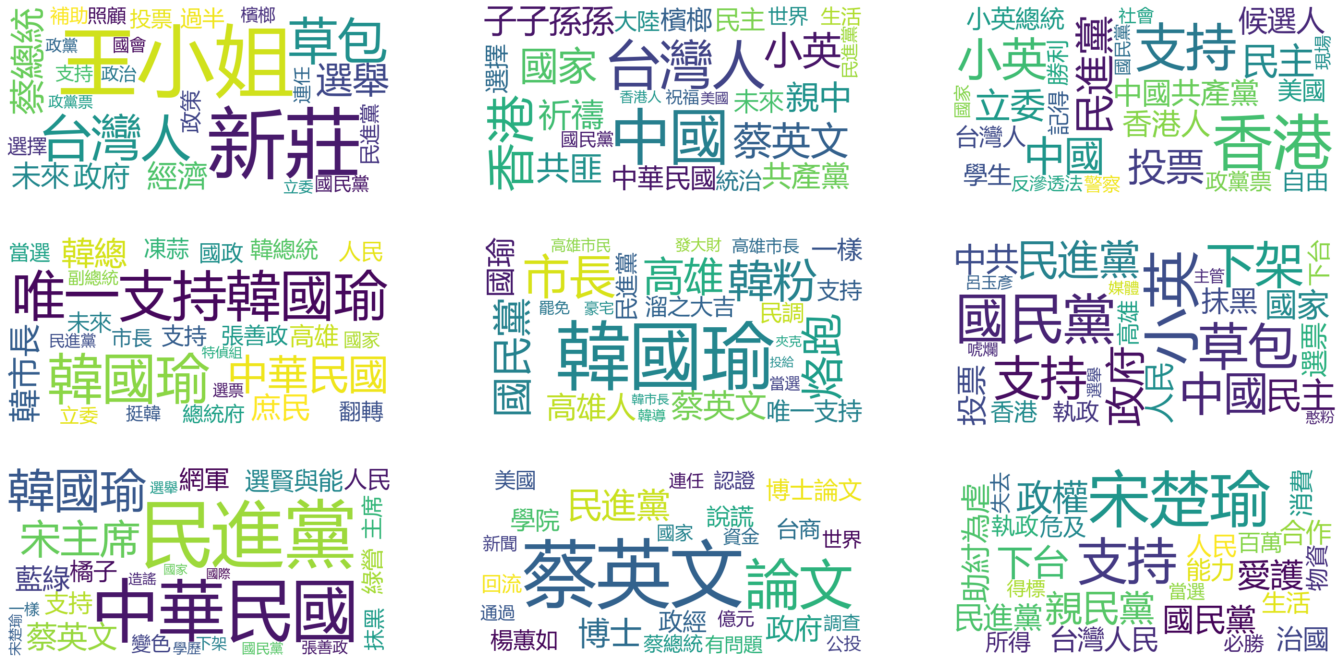

In [29]:
topics = n_components
# leng =  n_components/3 # 兩列
leng = 3
plt.figure(figsize=(24, 12))

for i, data in enumerate(lda_model.components_):
    ndf = pd.DataFrame([data],
                       columns=vectorizer.get_feature_names()).T
    ndf = ndf.reset_index()
    ndf.columns = ['index','freq']
    ndf = ndf.sort_values('freq').tail(25)
    # plot wordcloud
    d = {}
    for k,v in zip(ndf['index'], ndf['freq']):
        d[k] = int(v)
    
    plt.subplot(3, leng, i+1)
    wordcloud = WordCloud(font_path='C:/Windows/Fonts/Microsoft YaHei/msyh.ttc',
                          width=800,
                          height=400,
                          background_color="white").generate_from_frequencies(d)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
plt.show()

### 確認分群結果

- Topic0： (韓黑議題) 新莊王小姐
- Topic1： (國家認同) 擔心候選人過度親中，讓下一代被中國統治
- Topic2： (香港民主) 擔心台灣未來會變成跟香港一樣/反送中
- Topic3： (庶民總統) 庶民總統，相信韓是庶民的化身/形象
- Topic4： (帶職參選) 烙跑、溜之大吉 
- Topic5： (下架國民黨) 認為韓&支持者在唬爛、憨粉，鼓勵選民回家投票 
- Topic6： (藍綠都一樣) 藍綠都一樣, (中華民國)保衛戰 
- Topic7： (博士論文) 質疑才英文論文的正當性、認為韓在網路上被抹黑
- Topic8： (挺宋話題) 肯定宋的執政能力，希望宋能平衡所得跟物價的距離

In [32]:
# num_topic = 8
# for author in df_document_topic.loc[df_document_topic['dominant_topic']==num_topic].sort_values('Topic'+str(num_topic),ascending=False).index:
#     print(author)
#     print(comments.loc[comments['SOURCE']==author,'TEXT3'].values[0])
# #     print('\n=====\n')
# #     print(comments.loc[comments['AUTHOR']==author,'TEXT3'].values[0])
#     print('\n====================\n')
# #     break

### 分群數量

In [30]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,15
1,8,14
2,4,14
3,2,14
4,7,13
5,5,11
6,6,10
7,1,5
8,3,4


In [33]:
df_document_topic['Topic'] = np.select(condlist=[df_document_topic['dominant_topic']==0,
                                                df_document_topic['dominant_topic']==1,
                                                df_document_topic['dominant_topic']==2,
                                                df_document_topic['dominant_topic']==3,
                                                df_document_topic['dominant_topic']==4,
                                                df_document_topic['dominant_topic']==5,
                                                df_document_topic['dominant_topic']==6,
                                                df_document_topic['dominant_topic']==7,
                                                df_document_topic['dominant_topic']==8],
                                       choicelist=['韓黑議題','國家認同','香港民主','庶民總統',
                                                   '帶職參選','下架國民黨','藍綠都一樣','博士論文','挺宋話題'])
df_document_topic = df_document_topic.reset_index()
df_document_topic

,SOURCE,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,dominant_topic,Topic
0,100000036710110,0.01,0.01,0.01,0.01,0.01,0.40,0.26,0.28,0.01,5,下架國民黨
1,100000042799436,0.00,0.00,0.17,0.00,0.23,0.47,0.13,0.00,0.00,5,下架國民黨
2,100000106545512,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,4,帶職參選
3,100000169348902,0.00,0.00,0.16,0.07,0.32,0.28,0.17,0.00,0.00,4,帶職參選
4,100000189732330,0.01,0.90,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1,國家認同
5,100000239611720,0.00,0.00,0.00,0.83,0.06,0.00,0.00,0.09,0.00,3,庶民總統
6,100000319616052,0.00,0.00,0.80,0.00,0.00,0.17,0.00,0.00,0.00,2,香港民主
7,100000351410896,0.01,0.01,0.01,0.01,0.01,0.74,0.01,0.01,0.17,5,下架國民黨
8,100000379747963,0.06,0.00,0.10,0.00,0.67,0.03,0.11,0.00,0.04,4,帶職參選
9,100000382399817,0.00,0.02,0.00,0.72,0.07,0.20,0.00,0.00,0.00,3,庶民總統


## 情感分析
- 講者 & 公司介紹(1.5 Min)
- 介紹一下之前在PyCon做的分析成果(5 Min)
  - 為什麼做這麼分析? 因為選舉的風向很亂&有網軍的議題
  - 視覺化之後可以看到候選人 & 身邊的人在討論什麼話題
  - 但是分享完有一位會眾就提問說，如果有人故意亂放話，在這裡會不會誤把他當成KOL? 
    - 這邊可以拿劉斗，當做一個梗
- 進入本次主題--情感分析介紹
  - SNA 中是由 vertex 跟 edge 組合而成，在這裡我們有用了 vertex 的資訊，edge還沒有使用
  - edge 可以怎麼用呢? egde很適合用來判斷正負向的情感，也就是說如果我們看到某個vertex身邊的人對他都是負面的情感，那我們就可以知道他是跑來搗亂的
  - 什麼是情感分析呢? 情感分析就是判斷文本是正向/負向的情感，舉個例子，我如果對韓國瑜說了一句「唯一支持韓國瑜選總統後援會」的話，很明顯我就是對韓國瑜有正向的情感；但是我如果說的是「唯一支持韓國瑜草包選總統後援會」，我們透過語義的分析就可以知道他是在反諷。為什麼支持草包選總統呢?因為這樣對手陣營就更容易獲得勝利(梗，PS：這是一個用戶的名稱，先將草包兩個字藏起來讓大家以為這是支持，之後再Show出草包) 
- 所以要怎麼做情感分析呢? 今天我會跟大家分享幾個方法


- 說起來很簡單，但是實際上在做情感分析也會遇到許多挑戰，

### 統計值法
- 直接用資料中的正負向分數
- 優點是簡單，容易、但是缺點是很多資料沒有label
  - 像是PPT, Google Play 的留言資料都有分數，但FB的資料沒有qq
  Facebook 的資料不像 Ptt 的結構有推(Pos)或噓(Neg)，

### 字典法
- 台大情感分數字典(http://academiasinicanlplab.github.io/)
  - https://rdrr.io/rforge/tmcn/man/NTUSD.html
- 大連理工大學
  - https://github.com/ZaneMuir/DLUT-Emotionontology

### 既有套件法
- 目前比較多是英文或簡體中文，要定期維護
  - 可以適當的搭配Google 翻譯
- NLTK
- SNOWNLP
   - https://github.com/TLYu0419/DataScience/blob/master/Natural_Language_Processing/Natural_Language_Processing_with_Python/04-Semantics-and-Sentiment-Analysis/04-Sentiment-Analysis-Assessment-Solutions.ipynb
- Jiagu
  - https://github.com/ownthink/Jiagu
  
- 缺點是情感分析很吃語料庫、產業

#### nltk

In [69]:
import nltk
# nltk.download('vader_lexicon')

In [68]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
# Write a review as one continuous string (multiple sentences are ok)
review = 'This movie portrayed real people, and was based on actual events.'
# Obtain the sid scores for your review
sid.polarity_scores(review)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

#### snownlp

In [45]:
from snownlp import SnowNLP
s = SnowNLP(u'这个东西真心很赞')
s.sentiments

0.9769551298267365

In [59]:
s = SnowNLP(u'幾十年從沒像此時風雨飄搖')
s.han#sentiments

'几十年从没像此时风雨飘摇'

#### jiagu

In [61]:
doc = '北京如果能正視台灣的聲音，改變處理兩岸關係的態度，和台灣共同促成兩岸的和解及和平對話，相信一定可以化解區域的緊張局勢。'
import jiagu

# text = '很讨厌还是个懒鬼'
sentiment = jiagu.sentiment(doc)
print(sentiment)

('negative', 0.9991722541504778)


#### 衍生：Google翻譯
所以中文的文本要怎麼辦?

In [62]:
from googletrans import Translator
translator = Translator()
#zh-tw to en
translations = translator.translate(['唯一支持草包韓國瑜選高雄市民', '還不錯', '那麼你呢?'], dest='en')
for translation in translations:
    print(translation.origin, ' -> ', translation.text)

唯一支持草包韓國瑜選高雄市民  ->  The only person who supports the Korean Yuga election of Kaohsiung citizens
還不錯  ->  not bad
那麼你呢?  ->  how about you?


### Train 模型法
- 會需要處理label的問題
- 自己 Label 資料，但你會Label到死
- 用PPT的資料來Train模型，然後把FB的資料放進去預測
- https://github.com/isnowfy/snownlp
- 如果你有自己的語料庫，而且也有Label的資料，那麼你就可以自己train模型
- 簡單一點可以用bagofwords/tfidf, 進階一些可以用詞向量

### 爬蟲法
- 百度api
- waiser lab
https://www.wisers.ai/browse/sentiment-analysis/demo/

In [70]:
import requests

In [92]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36',
#           'Cookie': 'ROUTEID=.corp-myweb01; pll_language=zh-hk; _ga=GA1.2.1869075746.1602425762; _gid=GA1.2.805471831.1602425762; _gat_https%3A%2F%2Fwww.wisers.ai%2Fbrowse%2Fsentiment-analysis%2Fdemo%2F=1',
#           'DNT': '1'
          }

In [93]:
url = 'https://www.wisers.ai/?api=ailab-demo-apilb.wisers.com:8000/senti/api/processtext'
data = {"text":"幾十年從沒像此時風雨飄搖","model":"dl","output_level":"subject","show_scores":'true'}
resp = requests.post(url, json=data, headers=headers)

In [94]:
resp.text

'{"docid":null,"is_successful":true,"message":"","overall_res":{"sentiment":-1,"sentiment_score":0.41},"detail_res":[]}'

In [77]:
# https://github.com/baidu/Senta

# ------------- SNA + NLP -------------
- 結合SNA與NLP的成果，我們發現各各社群討論的話題有明顯的差異
- 用 沉浸式簡報的方式，簡單回顧一下KOL們說了些什麼

- NLP與位在網絡核心也會有關係!
- KOL -> Key Opinion Consumer

----
- 韓國瑜陣營能夠製造話題，吸引大家來留言
- 📌但是其中不乏反對他的人
----
- 應用：

SNA 跟 NLP 的疊圖
    

In [40]:
ver = pd.DataFrame([sg.vs['name'],sg.vs['label']],index=['SOURCE','Label']).T
ver = pd.merge(ver, df_document_topic.loc[:, ['SOURCE','dominant_topic','Topic']], how='left',on='SOURCE')
ver.sort_values('dominant_topic')

,SOURCE,Label,dominant_topic,Topic
86,100019041369730,陳思瑋,0,韓黑議題
84,100002411487520,陳宥熙,0,韓黑議題
77,100016992458347,邱蕙芯,0,韓黑議題
70,100002121669552,蔣兆龍,0,韓黑議題
68,100002589483338,蔡宗碩,0,韓黑議題
29,100007142430285,俞麗梅,1,國家認同
34,100028324085078,呂玉彥,1,國家認同
45,100004358619003,徐玉龙,1,國家認同
46,74033546957,搶救台灣行動聯盟,1,國家認同
98,100009404025938,黃祥和,1,國家認同


In [35]:
sg = g.subgraph(kols['name'])
sg.vs['dominant_topic'] = ver['dominant_topic']
sg.vs['Topic'] = ver['Topic']

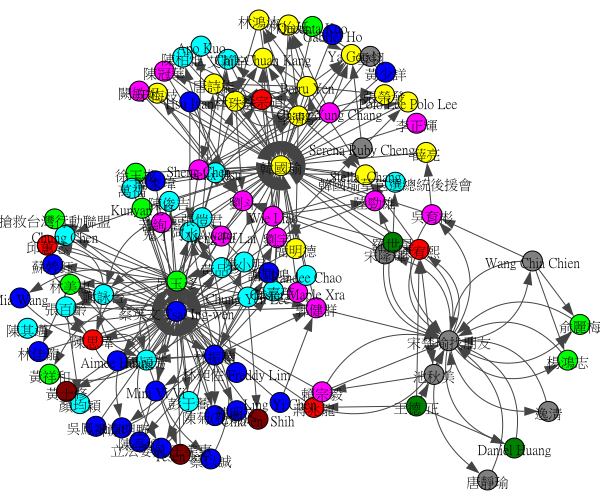

In [36]:
pal = igraph.drawing.colors.ClusterColoringPalette(9) # 9個主題
sg.vs['color'] = pal.get_many(sg.vs['dominant_topic'])
layout = sg.layout_kamada_kawai(maxiter=10000)
igraph.plot(sg, layout = layout,bbox=(0,0,600,500))

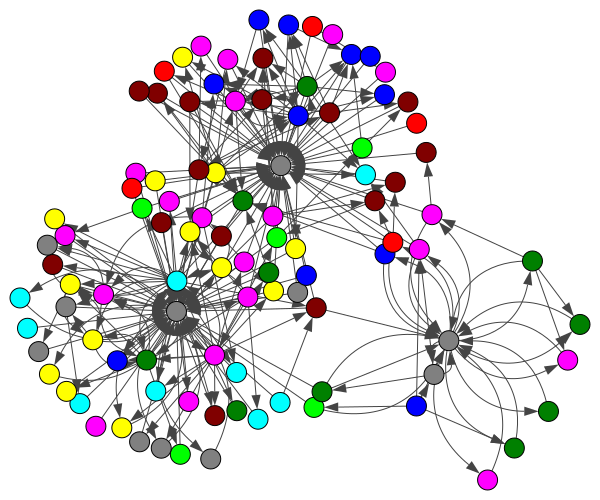

In [45]:
pal = igraph.drawing.colors.ClusterColoringPalette(9) # 9個主題
sg.vs['color'] = pal.get_many(sg.vs['dominant_topic'])
sg.vs['label'] = ''
layout = sg.layout_kamada_kawai(maxiter=10000)
igraph.plot(sg, layout = layout,bbox=(0,0,600,500))

  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15739 sha256=6ba4c7bcd0d3cefb443c35781debd592b9b855d0f8bc6c14f54d60285bc4211d
  Stored in directory: c:\users\tl_yu\appdata\local\pip\cache\wheels\20\da\eb\a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans
Note: you may need to restart the kernel to use updated packages.


唯一支持草包韓國瑜選高雄市民  ->  The only person who supports the Korean Yuga election of Kaohsiung citizens
還不錯  ->  not bad
那麼你呢?  ->  how about you?


# ------------- SNA的動態觀察 -------------
- 有時間在做!
- [用python分析《三国演义》中的社交网络.ipynb](https://github.com/blmoistawinde/hello_world/blob/master/sanguo_network/用python分析《三国演义》中的社交网络.ipynb)

# ------------- 結語 -------------

- 到底小英的高票是因為支持還是因為不喜歡韓??
  這邊可以列一些代表性的留言
- 透過SNA可以找到哪些人位在網絡的核心位置，接著可以透過NLP了解民眾的想法
- KOL 反映了民眾的想法，希望不同陣營的候選人可以針對這些議題正面回應!

- 政治獻金再也不用兩邊押寶(誤
- 不同產業/領域的關聯資料的意義有很大的差異，也不會每個鏈接都有意義。分析者在分析時還是需要結合Domain Knowkedge進行解析
    - 社群： 找出 KOL 幫助行銷
    >  找出 KOL 與KOL的興趣/偏好，避免KOL流失 (做出幾個標籤，怎麼做，怎麼貼)
    - 人資:  離職風險偵測
    - 電信:  流失風險偵測(人)
    - 金融:  偵測異常金流、
    - 客服： 服務流程設計(服務流程), 服務間的關聯，設計最適的服務流程、來電客訴訊號要求減免月租、取消違約金
    - 最後一個留給大家想，如果有任何的討論/建議我都會非常感謝!
> 不管你的身份是想要找到KOL幫你轉播訊息，或者你是分析師想要找到KOL，或者是一般民眾想要識別出真/假的KOL，都希望你會在這場演講中有收穫
> 資料會釋出，有興趣的人可以到以下網址尋找


# QA時間(5分)

# ------------- 潛在提問 -------------
- 網軍議題
> 其實在投稿的時候只是想要認真的用資料聊八卦，結果6月的時候就被罷免，讓這個議題突然變得很敏感。不過就像在前面提到的透過節點重要性的方式可以幫助我們區辨出真正的KOL和網軍。
- 要怎麼選擇filter的critical value
> 這個需要評估你有多少的資源，除了人力，還有你的時間，時間多的話就可以看得多一些。相反的話則看前面就好。畢竟不會每個關聯都很重要。。例如對於金融業在抓異常金流的時候，如果金流只有50/100，顯然就不是這麼重要.

# 資料確認

## 互動

In [32]:
Interact = pd.concat([pd.read_pickle('data/Interactive/Interactive_Comments.pkl'),
                      pd.read_pickle('data/Interactive/Interactive_Replies.pkl')],
                     ignore_index = True)
Interact = Interact.loc[Interact['TIME'].between('2019-11-11','2020-01-11',True),:]

In [67]:
# Interact.loc[Interact['SOURCE_NAME']=='Grande Li',]
Interact.loc[Interact['SOURCE']=='232716627404',]

,SOURCE_NAME,SOURCE,TIME,TARGET_NAME,TARGET
1571233,陳菊(花媽),232716627404,2019-11-17 09:09,蔡英文 Tsai Ing-wen,46251501064
1829163,陳菊(花媽),232716627404,2019-12-19 19:28,蔡英文 Tsai Ing-wen,46251501064


## 留言

In [33]:
comments = pd.concat([pd.read_pickle('data/Comments/Comments_201911.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']],
                      pd.read_pickle('data/Comments/Comments_201912.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']],
                      pd.read_pickle('data/Comments/Comments_202001.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']],
                      pd.read_pickle('data/Replies/Replies201911.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']],
                      pd.read_pickle('data/Replies/Replies201912.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']],
                      pd.read_pickle('data/Replies/Replies202001.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']]],
                    ignore_index=True)
comments = comments.loc[comments['TIME'].between('2019-11-11','2020-01-11',True),:]
comments = comments.loc[comments['TEXT']!='',]

In [35]:
# comments.loc[comments['NAME']=='Grande Li',]
comments.loc[comments['NAME']=='李進明',]
# comments.loc[comments['AUTHOR']=='100002080445623',]

,NAME,AUTHOR,TIME,TEXT,COMMENTID
2152281,李進明,100009219531853,2019-11-18 14:19,江學文,554723875329400
2152323,李進明,100009219531853,2019-11-18 17:16,蔡偉國,457267661860748
2152324,李進明,100009219531853,2019-11-18 17:17,伍浩,793176901152282
2152325,李進明,100009219531853,2019-11-18 17:18,莫生人,934043256979097
2152326,李進明,100009219531853,2019-11-18 17:24,莫生人,231668807821186
...,...,...,...,...,...
2453235,李進明,100009219531853,2019-12-21 16:47,Tsou Feng-Ho,185488972602456
2459970,李進明,100009219531853,2019-12-13 15:37,Lin Robin,2553815181381340
2460012,李進明,100009219531853,2019-12-17 18:06,黑韓聊天室 真實版在此！韓國瑜~與市長獎畢業生一起分享生命中榮耀的喜悅2019年6月26日\...,752998928552038
2460578,李進明,100009219531853,2019-12-17 17:39,Yi-Kai Chen,2793301660729340


In [23]:
for i in list(set(comments.loc[comments['AUTHOR']=='100002080445623',]['TEXT'])):
    print(i)

這四年您過得好嗎？這四年您感動嗎？貪腐、傲慢、肥貓、1450、空污、讓您感動了嗎？把票投給讓人民感動，願意培育下一代，建立一個清廉政府，期望人民過好日子的韓國瑜！
#2020全力支持韓國瑜總統挺進總統府 12/29風雨無阻力挺韓國瑜，足以證明庶民是頭家，韓國瑜的勝選是庶民大勝利，未來的四年在您的手中！團結吧~投票！
#唯一支持韓國瑜,✌️✌️✌️ 雨澆不熄庶民心中的怒火！唯一下架空心菜『讀稿機』與背後這顆新潮瘤！翻轉吧台灣！自己的命用選票自己救！等一個人！韓國瑜！111團結吧~投票！
#2020支持韓國瑜總統張善政副總統挺進總統府 重啟特偵組安打「得分」，力挺韓總統擊出立委過半的「紅不讓」！
#2020全力支持韓國瑜總統挺進總統府 我不在乎風雨！更不在乎泥濘！雙手揮舞🇹🇼心中熱血沸騰！12/29我站出來了！滿滿的激情與感動，111鐵定韓國瑜總統凍蒜！✌️✌️✌️ 西班牙馬得里舉行的聯合國氣候會議「2020年氣候變遷績效指標」台灣在總排名與去年相較退步三名，排名59名，在61個評比國家中居倒數第三名。溫室氣體排放台灣被評比非常差。以煤養綠是殘害全民健康！111用選票救自己的命！團結吧~投票翻轉台灣！
#2020全力支持韓國瑜總統張善政副總統挺進總統府 等一個人！韓總統好！ 風雨無阻挺韓庶民站出來！ 西班牙馬得里舉行的聯合國氣候會議「2020年氣候變遷績效指標」台灣在總排名與去年相較退步三名，排名59名，在61個評比國家中居倒數第三名。溫室氣體排放台灣被評比非常差。以煤養綠是殘害全民健康！
#2020全力支持韓國瑜總統張善政副總統挺進總統府 重啟特偵組安打「得分」，力挺韓總統擊出滿壘的「紅不讓」！
#2020全力支持韓國瑜總統挺進總統府 12/29庶民挺韓站出來！
台中在等一個人！
#再讓旗海飄揚🇹🇼🇹🇼🇹🇼
#唯一支持韓國瑜✌️✌️✌️ 2020選🥬或選🐟？
🐭告訴您：2020總統🐭🐟！
不🐭🥬😄😄😄
#2020力挺韓國瑜 12/29挺韓進總統府，庶民站出來！
台中在等一個人！
#再次讓旗海飄揚🇹🇼🇹🇼🇹🇼
#唯一支持韓國瑜 重啟特偵組安打「得分」，力挺韓總統擊出一支滿壘的「紅不讓」！
#2020全力支持韓國瑜總統挺進總統府 1124全民滅東廠翻轉高雄！
0111下架民進黨翻轉台灣！
#2020全力支持韓國瑜總統張善政副總統挺進總統府 這四年您過得好嗎？這四年您感動嗎

In [15]:
# 讀取回覆資料
files = os.listdir('data/Replies')
Replies = []
for i in files:
    ndf = pd.read_pickle('data/Replies/'+ i)
    ndf = ndf.loc[:,['NAME', 'AUTHOR', 'TIME', 'PARENTCOMMENTID','TEXT']]
    gc.collect()
    print(i, ndf.shape)
    Replies.append(ndf)
Replies = pd.concat(Replies, ignore_index=True)
Replies.columns = ['SOURCE_NAME', 'SOURCE', 'TIME', 'PARENTCOMMENTID','TEXT']
Replies['PARENTCOMMENTID'] = Replies['PARENTCOMMENTID'].apply(lambda x: x.split('_',-1)[-1])
Replies = Replies.drop_duplicates(keep='first')
print(Replies.shape)

Replies201901.pkl (60392, 5)
Replies201902.pkl (40896, 5)
Replies201903.pkl (62983, 5)
Replies201904.pkl (78545, 5)
Replies201905.pkl (94891, 5)
Replies201906.pkl (159674, 5)
Replies201907.pkl (83711, 5)
Replies201908.pkl (121623, 5)
Replies201909.pkl (100832, 5)
Replies201910.pkl (164424, 5)
Replies201911.pkl (166414, 5)
Replies201912.pkl (234096, 5)
Replies202001.pkl (211280, 5)
Replies202002.pkl (71839, 5)
Replies202003.pkl (75284, 5)
Replies202004.pkl (22647, 5)
(1690033, 5)


In [37]:
# del Replies
Interact = pd.concat([pd.read_pickle('data/Interactive/Interactive_Comments.pkl'),
                      pd.read_pickle('data/Interactive/Interactive_Replies.pkl')],
                     ignore_index = True)

In [18]:
Interact

,SOURCE_NAME,SOURCE,TIME,TARGET_NAME,TARGET
0,蘇坤河,100004142288250,2019-01-02 13:39,蔡英文 Tsai Ing-wen,46251501064
1,陳均閎,100029164640328,2019-01-01 23:07,蔡英文 Tsai Ing-wen,46251501064
2,Judy Huang,100005098955012,2019-01-03 19:42,蔡英文 Tsai Ing-wen,46251501064
3,Richard Wen,100015364202796,2019-01-11 02:16,蔡英文 Tsai Ing-wen,46251501064
4,Danny Young,100002525061754,2019-01-08 20:51,蔡英文 Tsai Ing-wen,46251501064
...,...,...,...,...,...
4124530,Nan Li,100007582958597,2020-04-06 08:38,廖常粟,100000621263520
4124531,游秋水,1590334267,2020-04-09 22:59,廖常粟,100000621263520
4124532,廖常粟,100000621263520,2020-04-09 23:34,廖常粟,100000621263520
4124533,JoJo Lee,100006553658265,2020-04-04 15:05,Yick Fung,780109611


In [5]:
# Interact.loc[Interact['TARGET_NAME']=='艾莉緹',:]
Interact.loc[Interact['TARGET']=='1494192587412358',:]

NameError: name 'Interact' is not defined

In [ ]:
100019847109025	艾莉緹

# 測試

In [5]:
# pip install ckiptagger[tfgpu]

In [6]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

In [8]:
# data_utils.download_data_url("./")

In [9]:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

MemoryError: Unable to allocate 1.52 GiB for an array with shape (406737300,) and data type float32